# An Overview of Topic Modelling with LSA and LDA Algorithms

In [146]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import Counter
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [65]:
source_data = 'abcnews-date-text.csv'

In [66]:
data = pd.read_csv(source_data, parse_dates = [0], infer_datetime_format=True)

In [67]:
data.head(10)

,publish_date,headline_text
58939,2003-12-03,were ready to govern iraq president
918745,2014-11-25,toot for tio protest in darwin
217149,2006-02-07,opposition outlines fuel reduction burns failure
1089950,2017-07-14,the drum friday july 14
167776,2005-06-05,wa scores three environmental awards
102218,2004-07-11,iraq troop deployment key in japanese poll
786729,2013-05-14,youth to benefit from bushfire funding
674205,2012-02-22,newcastle rate rise
648715,2011-10-29,evacuations as chile volcano rumbles
689311,2012-04-22,didak stakes claim for magpies recall


In [68]:
indexed_data = data['headline_text']
indexed_data.index = data['publish_date']

data.sample(10)

,publish_date,headline_text
760045,2013-02-04,sa opposition more confident of smelter revamp
258400,2006-08-27,finn takes mobile phone throwing crown
958485,2015-06-15,wimmera residents urged to have say amid regional
631547,2011-08-09,obama seeks to calm stock market
13239,2003-04-23,sars threat closes beijing schools
112766,2004-08-31,us guard stomped on fingers of iraqi jail deta...
77848,2004-03-11,pm unveils 30b school funding boost
266360,2006-11-08,rba lifts interest rate as expected
840933,2013-12-12,no pay rise for aged care workers after coalit...
506774,2009-12-13,twins sought for cervical cancer hpv research


In [69]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

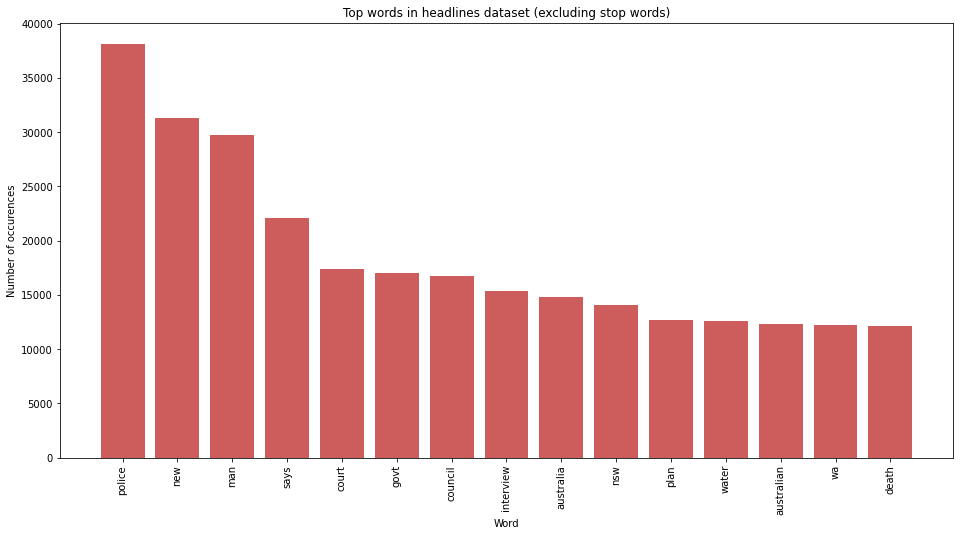

In [105]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=indexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values, color='indianred');
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [76]:
tagged_headlines = [TextBlob(indexed_data[i]).pos_tags for i in tqdm(range(indexed_data.shape[0]))]

100%|██████████| 1186018/1186018 [35:05<00:00, 563.38it/s] 


In [77]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  7706416
Mean number of words per headline:  6.497722631528358


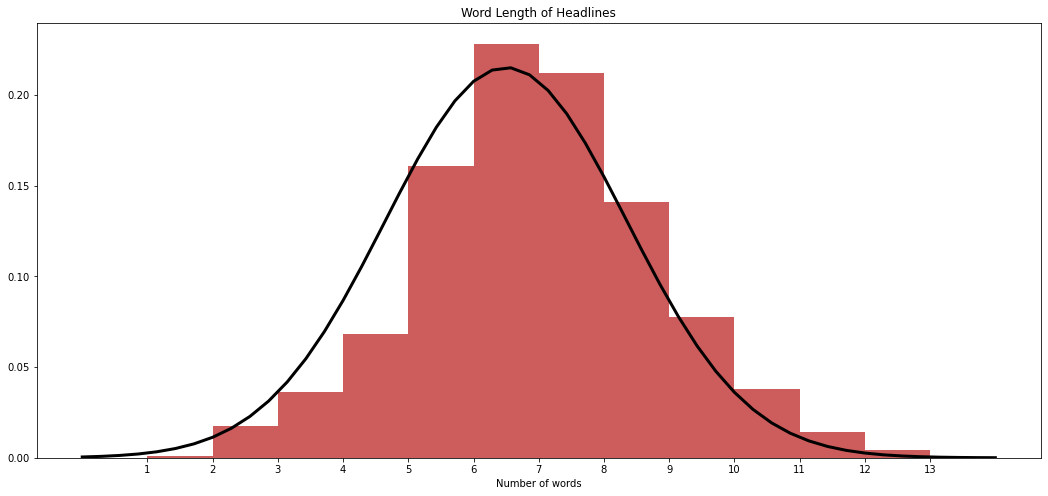

In [104]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True, color='indianred');
ax.plot(np.linspace(0,14,50), y, 'black', linewidth=3);
ax.set_title('Word Length of Headlines');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

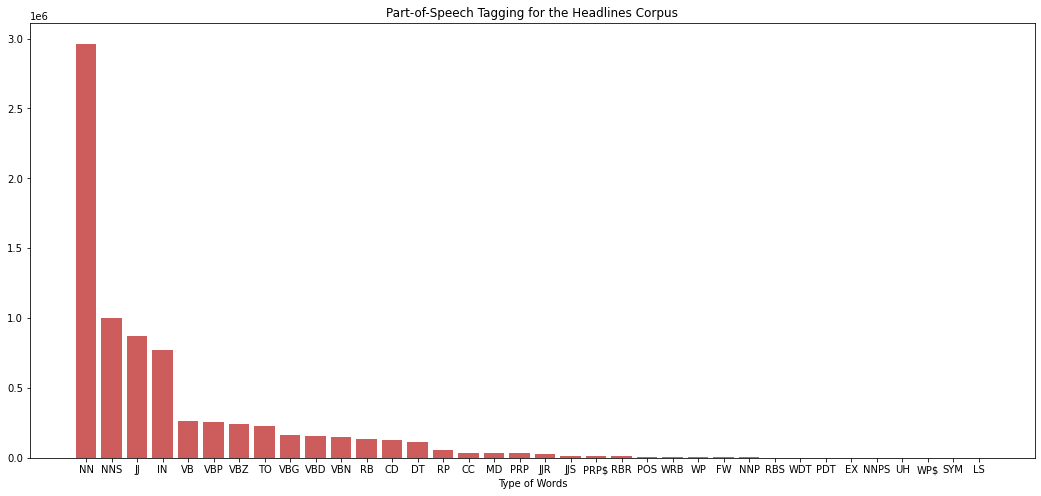

In [98]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts, color='indianred');
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for the Headlines Corpus');
ax.set_xlabel('Type of Words');

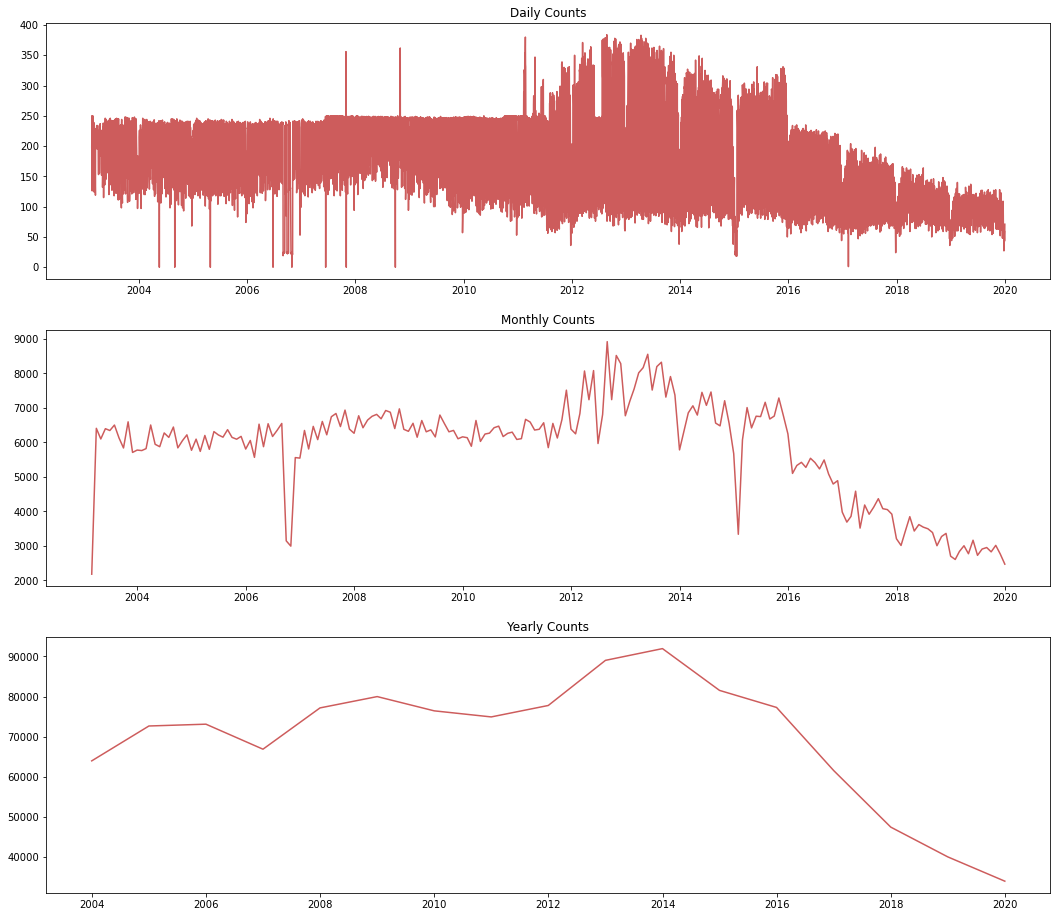

In [97]:
monthly_counts = indexed_data.resample('M').count()
yearly_counts = indexed_data.resample('A').count()
daily_counts = indexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts, color='indianred');
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts, color='indianred');
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts, color='indianred');
ax[2].set_title('Yearly Counts');
plt.show()

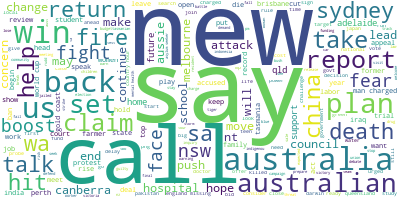

In [61]:
all_headlines = ','.join(list(indexed_data))

wordcloud = WordCloud(max_words=10000, background_color="white", contour_width=10, contour_color="red").generate(all_headlines)

wordcloud.generate(all_headlines)
wordcloud.to_image()
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()

In [108]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = indexed_data.sample(n=20000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[786]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[786]))

Headline before vectorization: qantas spokeswoman discusses strikes
Headline after vectorization: 
  (0, 12742)	1
  (0, 15069)	1
  (0, 4932)	1
  (0, 15392)	1


In [109]:
n_topics = 15

In [113]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [116]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [119]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [120]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [121]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  police probe attack drug assault man canberra officer seek murder
Topic 2:  man charged murder court jailed arrested accused bail stabbing dies
Topic 3:  new laws mayor zealand coach darwin gets boss campaign anti
Topic 4:  says pm minister labor iraq industry trump union state wont
Topic 5:  govt urged calls workers funding centre act claims community push
Topic 6:  council city plan water land seeks mayor plans development wants
Topic 7:  court face accused charges case high told faces sex trial
Topic 8:  australia day cup world south test final england second india
Topic 9:  nsw country hour rain election 2015 friday drum government 2014
Topic 10:  crash car killed dies woman dead road fatal injured driver
Topic 11:  interview nrl michael extended david john andrew speaks peter scott
Topic 12:  qld health coast school north gold rural weather west national
Topic 13:  death wa sa queensland china toll guilty fight government inquest
Topic 14:  plan water missing search powe

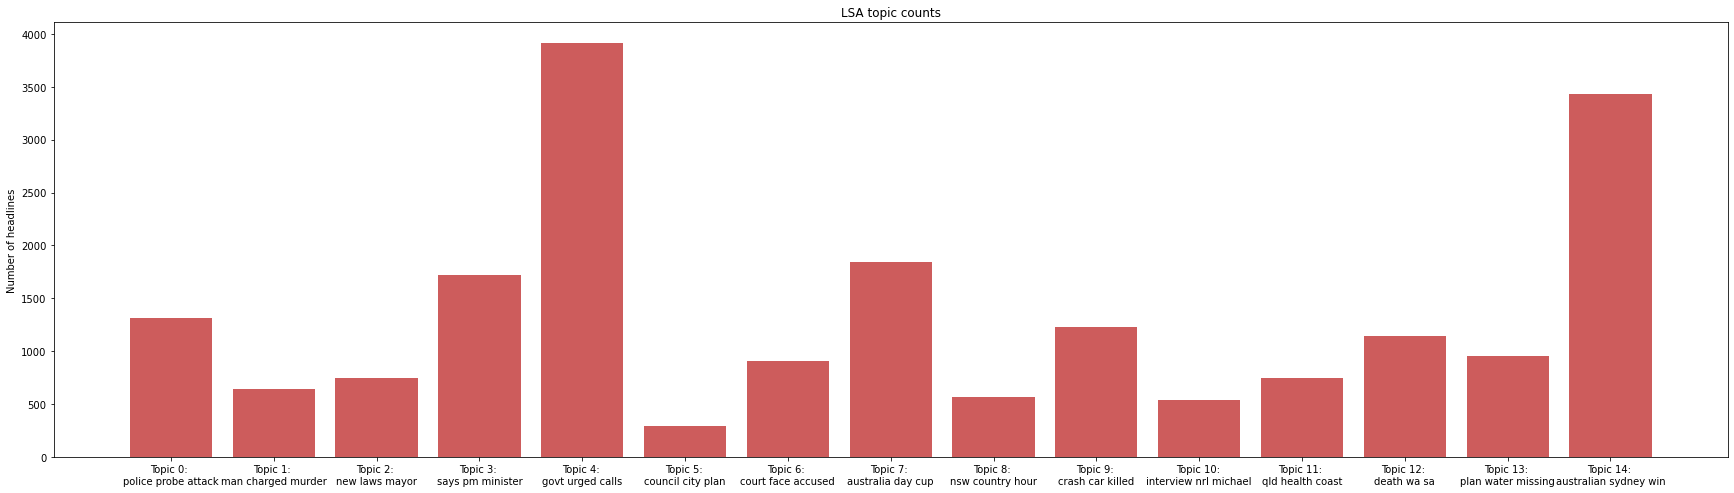

In [123]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(30,8))
ax.bar(lsa_categories, lsa_counts, color='indianred');
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [124]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.224s...
[t-SNE] Computed neighbors for 20000 samples in 21.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

In [126]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [127]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [131]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [132]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [133]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [134]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  day final melbourne house ban australia woman perth west record
Topic 2:  new says govt coast gold school deal boost funding help
Topic 3:  abc election business guilty world wins action attack campaign live
Topic 4:  police talks trial north threat residents river state new cyclone
Topic 5:  interview rural cup farmers national queensland year sa price high
Topic 6:  charges drug labor indigenous england return trump opposition union second
Topic 7:  man crash sydney murder dies accused police charged driver injured
Topic 8:  plan workers search plans hit road mayor continues housing asylum
Topic 9:  death claims war sa police anti parliament season councils inquest
Topic 10:  win south australia sex gets act jail weather chief push
Topic 11:  nsw water government report wa hospital killed child abuse inquiry
Topic 12:  council urged china iraq budget media green warns say mining
Topic 13:  court qld market face rise dead end man decision funds
Topic 14:  health calls change

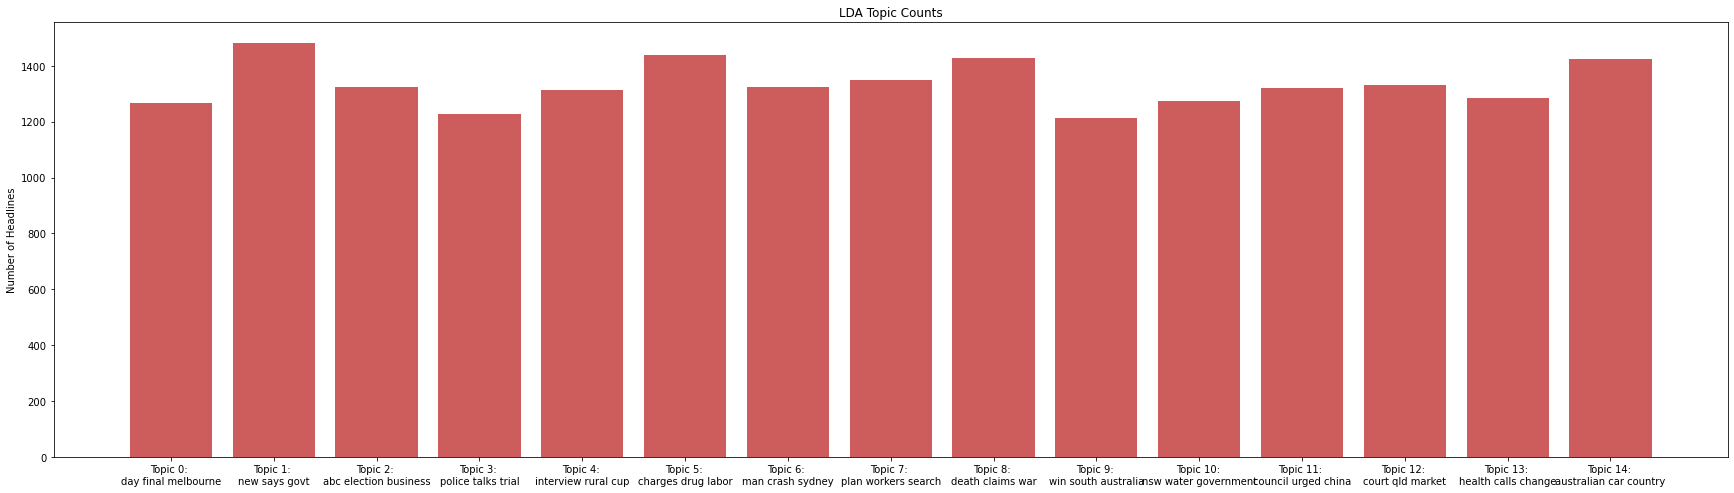

In [137]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(30,8))
ax.bar(lda_categories, lda_counts, color='indianred');
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA Topic Counts');
ax.set_ylabel('Number of Headlines');

In [138]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.260s...
[t-SNE] Computed neighbors for 20000 samples in 37.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

In [139]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [141]:
big_sample_size = 500000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = indexed_data.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

In [143]:
yearly_data = []
for i in range(2003,2019+1):
    yearly_data.append(indexed_data['{}'.format(i)].values)

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2019+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

print(yearly_topic_counts)

      Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  Topic 8  \
2003     4539     3590     4231     4167     3895     5051     3829     4153   
2004     5700     4771     4970     4792     5374     4911     4563     3733   
2005     4661     5326     4803     4030     3821     4985     4974     5686   
2006     3685     4761     4759     5012     5100     5043     4300     4326   
2007     4299     5063     4984     4877     5891     4812     5241     5106   
2008     5030     6097     5704     4923     5427     5171     5093     4910   
2009     4673     5319     5989     5661     4692     4632     4571     5576   
2010     5284     6030     4980     4423     5863     4027     4293     5102   
2011     5789     4979     4780     5776     4549     4925     6255     5127   
2012     6911     7875     5063     6348     5871     5628     5651     5742   
2013     6396     5166     5693     5602     6359     5796     5880     6356   
2014     4820     5256     4564     4897

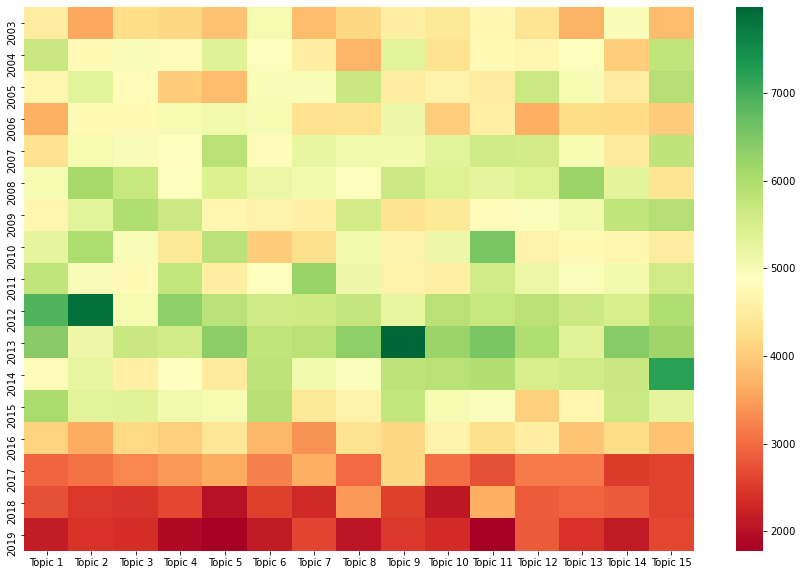

In [173]:
fig, ax = plt.subplots(figsize=(15,10))
sb.heatmap(yearly_topic_counts, cmap="RdYlGn", ax=ax);
plt.show()